In [1]:
import os
os.chdir("../")

import fiona
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import shapely
from shapely.geometry import Point
from shapely.ops import unary_union

import rasterio
import rasterio.mask
from rasterio.plot import show, show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray

import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

In [2]:
forest_path = os.getcwd() + "/data/raster/forest_loss_porijogi_wgs84.tif"
crop_path = os.getcwd() + "/data/raster/HARV_dsmCrop.tif"

In [3]:
forest = rasterio.open(forest_path)
print(f"profile: {forest.profile}")
forest_src = forest.read(1)

profile: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1326, 'height': 687, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002500000000000014, 0.0, 26.548502689,
       0.0, -0.0002500000000000043, 58.289435726), 'blockysize': 3, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [4]:
crop = rasterio.open(crop_path)
print(f"shape: {crop.shape}, count: {crop.count}, crs: {crop.crs}")
crop_src = crop.read(1)

shape: (1367, 1697), count: 1, crs: EPSG:32618


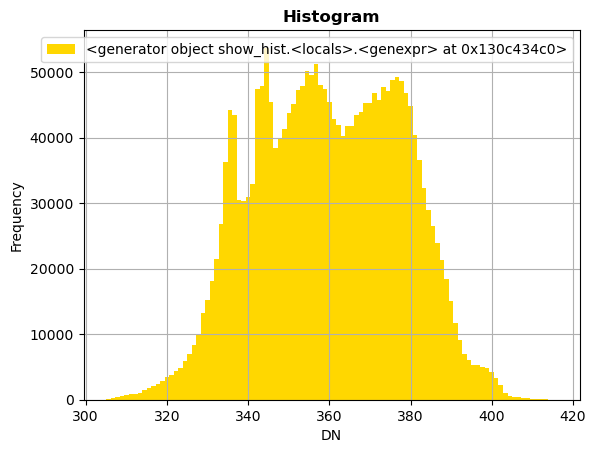

In [5]:
show_hist(crop_src, bins=100);

## Gridded World Population

In [6]:
gpw_path = os.getcwd() + "/../gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_30_sec.tif"

In [7]:
gpw = rasterio.open(gpw_path)
gpw_src = gpw.read(1)
print(f"profile: {gpw.profile}")

profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333333333387, 0.0, -180.0,
       0.0, -0.00833333333333387, 90.00000000001157), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [8]:
va = gpd.read_file(os.getcwd() + "/data/va_2020.zip")

def convert_to_2d(row):
    return shapely.wkb.loads(
        shapely.wkb.dumps(row, output_dimension=2))
va["geometry"] = va["geometry"].apply(convert_to_2d)

shapes = [poly for poly in va.geometry]

In [9]:
with rasterio.open(gpw_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

with rasterio.open(os.getcwd() + "/data/gpw_v4_va_30sec.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/var/folders/kn/jw0y9v615mjgg3_51g3s73zh0000gn/T/ipykernel_87215/3420593702.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  our_cmap = cm.get_cmap('hot_r', 10)


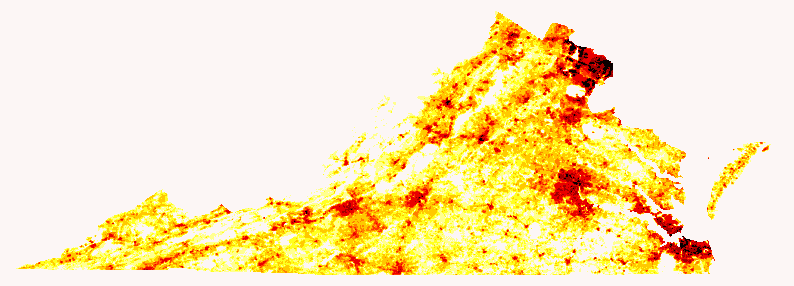

In [12]:
our_cmap = cm.get_cmap('hot_r', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 5)
ax.imshow(out_image[0], cmap=our_cmap, norm=norm)
ax.axis('off')
plt.show()

In [10]:
gpw_va = rasterio.open(os.getcwd() + "/data/gpw_v4_va_30sec.tif")
gpw_va_src = gpw_va.read(1)
gpw_va_src[gpw_va_src == gpw_va.nodata] = 0

In [11]:
def extract_val_from_raster(x, y):
    coord = Point(gpw_va.xy(x, y)[0], gpw_va.xy(x, y)[1])
    val = gpw_va_src[x, y]
    return [coord, val]

In [12]:
output_dict = {"geometry": [], "pd": []}
with tqdm(total=gpw_va_src.shape[0] * gpw_va_src.shape[1]) as pbar:
    for (x, y) in np.ndindex(gpw_va_src.shape):
        val_list = extract_val_from_raster(x, y)
        if (val_list != None):
            coord, val = val_list[0], val_list[1]
            output_dict["geometry"].append(coord)
            output_dict["pd"].append(val)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████| 360096/360096 [00:08<00:00, 40345.63it/s]


In [15]:
va_pd_gdf = gpd.GeoDataFrame(pd.DataFrame(output_dict))
va_pd_gdf.sample(5)

,geometry,pd
14390,POINT (-83.11250 39.34583),0.00000
55944,POINT (-77.82917 39.01250),14.82271
32944,POINT (-81.94583 39.19583),0.00000
107035,POINT (-78.32083 38.59583),0.00000
97089,POINT (-75.95417 38.67917),0.00000


In [17]:
print(va_pd_gdf[va_pd_gdf.pd == va_pd_gdf.pd.max()])
geocoder = Nominatim(user_agent="czhang")
address = geocoder.reverse("36.87083, -76.31250")
print(address)

                          geometry            pd
319037  POINT (-76.31250 36.87083)  26056.839844
Elizabeth River Trail, Norfolk, Virginia, 23507, United States


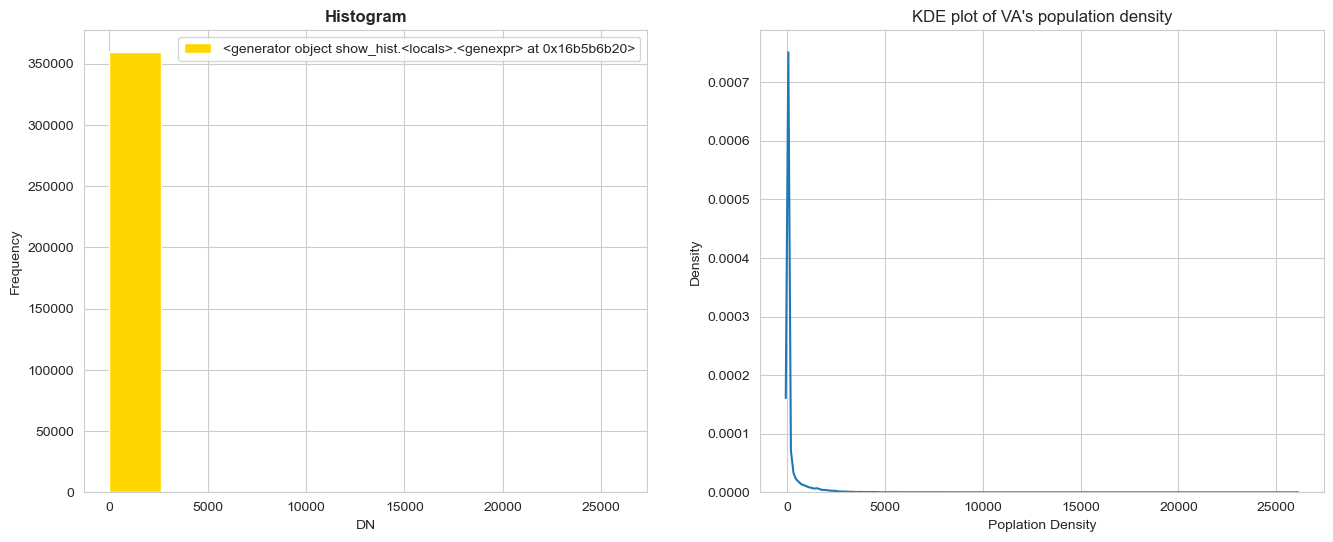

In [18]:
import seaborn as sns
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
show_hist(gpw_va_src, ax=ax1)
sns.kdeplot(data=va_pd_gdf, x="pd", ax=ax2)
ax2.set_xlabel("Poplation Density")
ax2.set_title("KDE plot of VA's population density")
plt.show()